In [1]:
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import os
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

from base_module import *
from bert import Bert

In [2]:
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print(f'device: {device}')

device: mps


In [3]:
df = pd.read_feather('../../dataset/preprocessed_data.feather')[['event_time', 'user_id', 'user_session', 'product_id', 'brand', 'category_id', 'category_code']]
df.head()

,event_time,user_id,user_session,product_id,brand,category_id,category_code
0,2019-10-01 00:00:00+00:00,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,44600062,shiseido,2103807459595387724,#unknown
1,2019-10-01 00:00:00+00:00,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,3900821,aqua,2053013552326770905,appliances.environment.water_heater
2,2019-10-01 00:00:01+00:00,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,17200506,#unknown,2053013559792632471,furniture.living_room.sofa
3,2019-10-01 00:00:01+00:00,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,1307067,lenovo,2053013558920217191,computers.notebook
4,2019-10-01 00:00:04+00:00,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,1004237,apple,2053013555631882655,electronics.smartphone


In [4]:
user_counts = df['user_session'].value_counts().reset_index()[['user_session', 'count']]
unique_user_sessions = list(user_counts[(user_counts['count'] >= 5) & (user_counts['count'] <= 50)]['user_session'])
df = df[df['user_session'].isin(unique_user_sessions)]

product_counts = df['product_id'].value_counts().reset_index()[['product_id', 'count']]
# 한 달에 100번 이상 선택받은 상품만 필터링
unique_product_ids = list(product_counts[product_counts['count'] >=100]['product_id'])

del user_counts, product_counts

In [5]:
word2index = {product_id: index + 2 for index, product_id in enumerate(unique_product_ids)}
word2index['<PAD>'] = 0
word2index['<UNK>'] = 1
word2index['[MASK]'] = len(word2index)
index2word = {index: word for word, index in word2index.items()}

vocab_size = len(word2index)
print(f'vocab size: {vocab_size}')

vocab size: 31350


In [6]:
sequence_data = df.groupby('user_session')['product_id'].agg(list).reset_index()['product_id'].tolist()
print(sequence_data[:3])

[[1005115, 1005105, 1005105, 5100816, 1004858, 1005104, 1003312, 1005212], [1004768, 1005098, 1005073, 1004871, 1004751, 1004653, 1005015, 1004871, 1003527, 1004871, 1005115, 1004249, 1005105, 1005135, 1004246, 1004870, 1004870, 1004870], [1004856, 1004856, 1004863, 1004834, 1004834, 1004834, 1004834, 1004834, 1004834, 1004834, 1004834]]


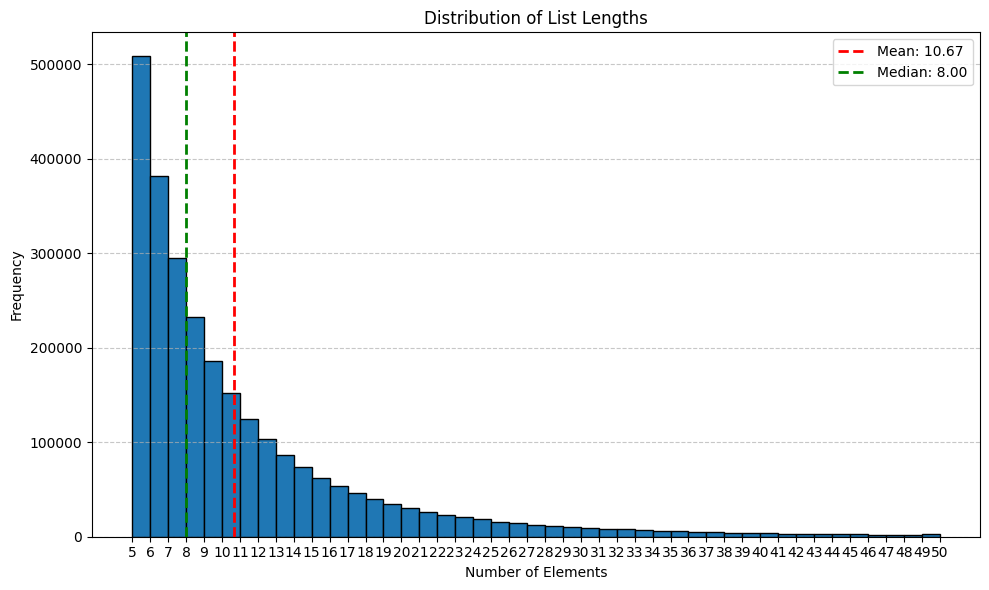

Minimum length: 5
Maximum length: 50
Mean length: 10.67
Median length: 8.00


In [7]:
lengths = [len(lst) for lst in sequence_data]

plt.figure(figsize=(10, 6))
plt.hist(lengths, bins='auto', edgecolor='black')

plt.title('Distribution of List Lengths')
plt.xlabel('Number of Elements')
plt.ylabel('Frequency')

plt.xticks(range(min(lengths), max(lengths)+1))

plt.grid(axis='y', linestyle='--', alpha=0.7)

mean_length = np.mean(lengths)
median_length = np.median(lengths)

plt.axvline(mean_length, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_length:.2f}')
plt.axvline(median_length, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_length:.2f}')

plt.legend()

plt.tight_layout()
plt.show()

print(f"Minimum length: {min(lengths)}")
print(f"Maximum length: {max(lengths)}")
print(f"Mean length: {mean_length:.2f}")
print(f"Median length: {median_length:.2f}")

In [8]:
min_len = 5
max_len = 20

In [9]:
class SequenceDataset(Dataset):
    def __init__(self, data, word2index, min_len, max_len, mask_only_last=False):
        self.word2index = word2index
        self.min_len = min_len
        self.max_len = max_len
        self.mask_only_last = mask_only_last

        self.sequences = []
        for product_ids in tqdm(data):
            # 같은 상품이 연속으로 클릭된 경우 한 번으로 환원
            clean_product_ids = []
            for i in product_ids:
                if (not clean_product_ids) or (clean_product_ids[-1] != i):
                    clean_product_ids.append(i)

            if len(clean_product_ids) < min_len:
                continue

            product_indices = [word2index.get(i, word2index['<UNK>']) for i in clean_product_ids]

            if mask_only_last and product_indices[-1] == word2index['<UNK>']:
                continue

            if all([i == word2index['<UNK>'] for i in product_indices[:max_len]]):
                continue

            self.sequences.append(product_indices)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        item_list = self.sequences[idx][:self.max_len]
        input_ids = item_list + [self.word2index['<PAD>']] * (self.max_len - len(item_list))  # padding
        if self.mask_only_last:
            mask_pos = len(item_list) - 1
        else:
            mask_pos = None
            while True:
                mask_pos = random.randint(0, len(item_list) - 1)
                if input_ids[mask_pos] != word2index['<UNK>']:
                    break
                
        target = input_ids[mask_pos]
        input_ids[mask_pos] = self.word2index['[MASK]']

        return (
            torch.LongTensor(input_ids),
            torch.LongTensor([mask_pos]),
            torch.LongTensor([target]),
        )

train_dataset = SequenceDataset(sequence_data[:200000], word2index, min_len, max_len, mask_only_last=False)
val_dataset = SequenceDataset(sequence_data[200000:210000], word2index, min_len, max_len, mask_only_last=True)

100%|██████████| 10000/10000 [00:00<00:00, 586132.28it/s]


In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [11]:
print(train_dataset[0])
print(val_dataset[0])

(tensor([    4,    10, 31349,    31,    57,    83,   421,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), tensor([2]), tensor([14]))
(tensor([ 6871,  4337,  4198,  3723,  8443,  5996,  3652,  2684, 31349,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), tensor([8]), tensor([7884]))


In [12]:
d_embed = 64
d_model = 64
n_layer = 2
h = 2
d_ff = d_model * 2

token_embed = TokenEmbedding(d_embed=d_embed, vocab_size=vocab_size)
pos_embed = PositionEmbedding(d_embed=d_embed, max_len=max_len)
embed = BertEmbedding(token_embed=token_embed, pos_embed=pos_embed)

attention = MultiHeadAttentionLayer(d_model=d_model, h=h, qkv_fc=nn.Linear(d_embed, d_model), out_fc=nn.Linear(d_model, d_embed))
position_ff = PositionWiseFeedForwardLayer(fc1=nn.Linear(d_embed, d_ff), fc2=nn.Linear(d_ff, d_embed))

encoder_block = EncoderBlock(self_attention=copy.deepcopy(attention), position_ff=position_ff, d_model=d_model)
encoder = Encoder(encoder_block=encoder_block, n_layer=n_layer)

generator = nn.Linear(d_embed, vocab_size)

model = Bert(
    embed=embed,
    encoder=encoder,
    generator=generator
).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2index['<PAD>']).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [13]:
def train(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader):
        input_ids, mask_pos, targets = [b.to(device) for b in batch]
        outputs = model(input_ids)
        loss = criterion(outputs[torch.arange(outputs.size(0)), mask_pos.squeeze(), :], targets.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    
    avg_loss = total_loss / len(dataloader)

    return avg_loss


def calculate_mrr(predictions, targets):
    mrr = 0
    for pred, target in zip(predictions, targets):
        ranking = (pred.argsort(descending=True) == target).nonzero().item()
        mrr += 1 / (ranking + 1)  # +1 because ranking is 0-indexed
    return mrr / len(targets)


def calculate_hr(predictions, targets, k=10):
    hr = 0
    for pred, target in zip(predictions, targets):
        topk = pred.argsort(descending=True)[:k]
        if target in topk:
            hr += 1
    
    return hr / len(targets)


def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    total_hr = 0
    total_mrr = 0
    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids, mask_pos, targets = [b.to(device) for b in batch]
            outputs = model(input_ids)
            loss = criterion(outputs[torch.arange(outputs.size(0)), mask_pos.squeeze(), :], targets.squeeze())
            total_loss += loss.item()

            # Calculate MRR
            predictions = outputs[torch.arange(outputs.size(0)), mask_pos.squeeze(), :]
            hr = calculate_hr(predictions, targets.squeeze(), k=10)
            total_hr += hr
            mrr = calculate_mrr(predictions, targets.squeeze())
            total_mrr += mrr

    avg_loss = total_loss / len(dataloader)
    avg_hr = total_hr / len(dataloader)
    avg_mrr = total_mrr / len(dataloader)
    return avg_loss, avg_hr, avg_mrr

In [14]:
model_save_dir = './'

In [15]:
if not os.path.isdir(model_save_dir):
    os.makedirs(model_save_dir)

n_epochs = 30
max_mrr = float("-inf")
early_stop_counter = 0

train_history = []
for epoch in range(n_epochs):
    train_loss = train(model, train_dataloader, criterion, optimizer)
    eval_loss, hr, mrr = evaluate(model, val_dataloader, criterion)

    print(f'Epoch: {epoch}, Train loss: {train_loss:.3f}, Eval loss: {eval_loss:.3f}, HR@10: {hr:.3f}, MRR: {mrr:.3f}')

    train_history.append(
        {
            'epoch': epoch,
            'train_loss': train_loss,
            'eval_loss': eval_loss,
            'mrr': mrr,
        }
    )

    if mrr > max_mrr:
        torch.save(
            copy.deepcopy(model).to(torch.device("cpu")).state_dict(),
            f"{model_save_dir}/bert4rec.pt",
        )
        max_mrr = mrr

print(f"max MRR: {max_mrr}")

with open(f"{model_save_dir}/train_history.json", "w") as f:
    f.write(json.dumps(train_history))

100%|██████████| 48/48 [00:22<00:00,  2.14it/s]


Epoch: 0, Train loss: 9.699, Eval loss: 9.554, HR@10: 0.032, MRR: 0.015


100%|██████████| 48/48 [00:22<00:00,  2.14it/s]


Epoch: 1, Train loss: 9.262, Eval loss: 9.361, HR@10: 0.034, MRR: 0.017


100%|██████████| 48/48 [00:21<00:00,  2.19it/s]


Epoch: 2, Train loss: 9.022, Eval loss: 9.183, HR@10: 0.039, MRR: 0.019


100%|██████████| 48/48 [00:21<00:00,  2.21it/s]


Epoch: 3, Train loss: 8.836, Eval loss: 9.044, HR@10: 0.052, MRR: 0.027


100%|██████████| 48/48 [00:22<00:00,  2.18it/s]


Epoch: 4, Train loss: 8.653, Eval loss: 8.892, HR@10: 0.075, MRR: 0.036


100%|██████████| 48/48 [00:22<00:00,  2.18it/s]


Epoch: 5, Train loss: 8.464, Eval loss: 8.724, HR@10: 0.086, MRR: 0.044


100%|██████████| 48/48 [00:22<00:00,  2.17it/s]


Epoch: 6, Train loss: 8.284, Eval loss: 8.571, HR@10: 0.097, MRR: 0.049


100%|██████████| 48/48 [00:21<00:00,  2.24it/s]


Epoch: 7, Train loss: 8.111, Eval loss: 8.418, HR@10: 0.111, MRR: 0.054


100%|██████████| 48/48 [00:22<00:00,  2.15it/s]


Epoch: 8, Train loss: 7.946, Eval loss: 8.276, HR@10: 0.120, MRR: 0.057


100%|██████████| 48/48 [00:21<00:00,  2.28it/s]


Epoch: 9, Train loss: 7.789, Eval loss: 8.151, HR@10: 0.134, MRR: 0.064


100%|██████████| 48/48 [00:21<00:00,  2.23it/s]


Epoch: 10, Train loss: 7.640, Eval loss: 8.026, HR@10: 0.139, MRR: 0.069


100%|██████████| 48/48 [00:20<00:00,  2.33it/s]


Epoch: 11, Train loss: 7.507, Eval loss: 7.923, HR@10: 0.145, MRR: 0.072


100%|██████████| 48/48 [00:20<00:00,  2.35it/s]


Epoch: 12, Train loss: 7.370, Eval loss: 7.822, HR@10: 0.154, MRR: 0.075


100%|██████████| 48/48 [00:20<00:00,  2.34it/s]


Epoch: 13, Train loss: 7.259, Eval loss: 7.720, HR@10: 0.161, MRR: 0.080


100%|██████████| 48/48 [00:21<00:00,  2.25it/s]


Epoch: 14, Train loss: 7.158, Eval loss: 7.648, HR@10: 0.162, MRR: 0.081


100%|██████████| 48/48 [00:21<00:00,  2.22it/s]


Epoch: 15, Train loss: 7.054, Eval loss: 7.566, HR@10: 0.169, MRR: 0.082


100%|██████████| 48/48 [00:20<00:00,  2.33it/s]


Epoch: 16, Train loss: 6.958, Eval loss: 7.491, HR@10: 0.177, MRR: 0.086


100%|██████████| 48/48 [00:20<00:00,  2.35it/s]


Epoch: 17, Train loss: 6.875, Eval loss: 7.426, HR@10: 0.184, MRR: 0.088


100%|██████████| 48/48 [00:21<00:00,  2.27it/s]


Epoch: 18, Train loss: 6.786, Eval loss: 7.374, HR@10: 0.185, MRR: 0.089


100%|██████████| 48/48 [00:20<00:00,  2.33it/s]


Epoch: 19, Train loss: 6.717, Eval loss: 7.309, HR@10: 0.188, MRR: 0.091


100%|██████████| 48/48 [00:21<00:00,  2.25it/s]


Epoch: 20, Train loss: 6.646, Eval loss: 7.261, HR@10: 0.195, MRR: 0.093


100%|██████████| 48/48 [00:20<00:00,  2.33it/s]


Epoch: 21, Train loss: 6.580, Eval loss: 7.214, HR@10: 0.199, MRR: 0.096


100%|██████████| 48/48 [00:20<00:00,  2.32it/s]


Epoch: 22, Train loss: 6.519, Eval loss: 7.170, HR@10: 0.202, MRR: 0.095


100%|██████████| 48/48 [00:21<00:00,  2.25it/s]


Epoch: 23, Train loss: 6.457, Eval loss: 7.131, HR@10: 0.199, MRR: 0.095


100%|██████████| 48/48 [00:21<00:00,  2.19it/s]


Epoch: 24, Train loss: 6.397, Eval loss: 7.096, HR@10: 0.206, MRR: 0.097


100%|██████████| 48/48 [00:21<00:00,  2.19it/s]


Epoch: 25, Train loss: 6.347, Eval loss: 7.076, HR@10: 0.206, MRR: 0.099


100%|██████████| 48/48 [00:21<00:00,  2.19it/s]


Epoch: 26, Train loss: 6.304, Eval loss: 7.031, HR@10: 0.211, MRR: 0.102


100%|██████████| 48/48 [00:21<00:00,  2.21it/s]


Epoch: 27, Train loss: 6.256, Eval loss: 7.006, HR@10: 0.209, MRR: 0.098


100%|██████████| 48/48 [00:21<00:00,  2.28it/s]


Epoch: 28, Train loss: 6.217, Eval loss: 6.970, HR@10: 0.216, MRR: 0.101


100%|██████████| 48/48 [00:21<00:00,  2.21it/s]

Epoch: 29, Train loss: 6.166, Eval loss: 6.937, HR@10: 0.212, MRR: 0.104
max MRR: 0.10362379760076068


In [16]:
product_id_to_category_code = dict(zip(df['product_id'], df['category_code']))

In [20]:
test_dataset = SequenceDataset(sequence_data[210000:211000], word2index, min_len, max_len, mask_only_last=True)
random_idx = random.randint(0, len(test_dataset))
input_ids, mask_pos, target = test_dataset[random_idx]
outputs = model(input_ids.unsqueeze(0).to(device))
pred = outputs[0, mask_pos, :].squeeze()
sorted_indices = pred.argsort(descending=True)

previewed_categories = []
for i in input_ids[:-1]:
    product_id = index2word[i.item()]
    if product_id in ('<PAD>', '[MASK]'):
        break
    if product_id == '<UNK>':
        continue
    category_code = product_id_to_category_code[product_id]
    previewed_categories.append(category_code)

top10_categories = []
for i in sorted_indices[:10]:
    product_id = index2word[i.item()]
    if product_id in ('<PAD>', '[MASK]'):
        break
    if product_id == '<UNK>':
        continue
    category_code = product_id_to_category_code[product_id]
    top10_categories.append(category_code)

print(f'previewed_categories: {previewed_categories}')
print(f'top10_categories: {top10_categories}')

100%|██████████| 1000/1000 [00:00<00:00, 438964.31it/s]

previewed_categories: ['apparel.shoes', 'apparel.shoes', 'apparel.shoes']
top10_categories: ['sport.bicycle', 'apparel.shoes', 'apparel.shoes', 'apparel.shoes', 'apparel.shoes', 'apparel.shoes', 'apparel.shoes.keds', 'apparel.shoes', 'apparel.shoes', 'apparel.shoes']
